# Introduction

Over the years, climate change has become a growing issue. The most alarming factor of climate change is that it is already in effect. Form rising temperatures and sea levels to an increase in wildfires and droughts, the direct consequence on the human population is a rising concern which requires the world's immediate attention.

The past decade has observed a boom in social media platforms. Social media platforms have enabled individuals to express their opinion on topics of their choice. This individual expression has formed a huge unstructured database containing messages, statuses, chats, and news feeds which can then be tapped into understanding the general sentiment towards a specific topic.

## Problem Definition

For this project, we will be analyzing tweets from Twitter that are associated with climate change. Twitter was chosen because it is a huge source of information with an average of 330 million monthly active users. The Twitter data will be used to gain a better insight into people's perception of the ongoing crisis. Furthermore, it will be used to assess if general perception of climate change has witnessed a change over time.

The **goals** of the project are:
1. Performing sentiment analysis to understand the trend in climate change awareness over a duration of time.
2. Performing sentiment analysis to understand whether sentiment towards climate change is related to other factors.

## About the Dataset

Source of the dataset:
* [Kaggle: Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset)
* [Twitter API](https://developer.twitter.com/en/docs)

# TOC

# Setup

First we need to load libraries and set up the environment.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import missingno as msno
import re
from pandarallel import pandarallel

# Matplotilb setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize= 14)
mpl.rc('xtick', labelsize= 12)
mpl.rc('ytick', labelsize= 12)

In [3]:
# set project DIR
PROJECT_DIR = os.getcwd()
PROJECT_DIR

'/Users/mahora65/Desktop/ML-group'

In [4]:
# install twarc
try:
    import twarc
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'twarc',])
    import twarc

In [5]:
# install tweepy
try:
    import tweepy
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'tweepy==4.5.0',])
    import tweepy

In [6]:
# Downloading the library and downloading nltk-files
!pip install geograpy3
!gepgrapy-nltk

zsh:1: command not found: gepgrapy-nltk


# Load the data

In this project we will use both *labelled data* from Kaggle and *unlabelled data* which we get from Twitter API.

## Labelled Data

> The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

This dataset aggregates tweets pertaining to climate change collected between 27 Apr 2015 and 21 Feb 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

Each tweet is labelled as one of the following classes:
* `2` (News): the tweet links to factual news about climate change.
* `1` (Pro): the tweet supports the belief of man-made climate change.
* `0` (Neutral): the tweet neither supports nor refutes the belief of man-made climate change.
* `-1` (Anti): the tweet does not believe in man-made climate change

Source: [Kaggle: Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset)

Size of Dataset: 43943 x 3

Attributes of the dataset:
* `sentiment`: the sentiment of the tweet.
* `message`: the text of the tweet.
* `tweet_id`: unique identifier for each tweet.

In [7]:
# Load labelled dataset

tweets_sentiment = pd.read_csv(os.path.join(PROJECT_DIR, 'data/labeled/twitter_sentiment_data.csv'), skiprows=1, names=['sentiment', 'message', 'id'])
tweets_sentiment.head()

,sentiment,message,id
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


We will try using Twitter API to get more *meta data* about each tweet.

In [8]:
# Import twarc expansions to get all tweet fields available
from twarc.expansions import (
    EXPANSIONS,
    TWEET_FIELDS,
    USER_FIELDS,
    MEDIA_FIELDS,
    POLL_FIELDS,
    PLACE_FIELDS
)
import tweepy
from datetime import datetime

## Authentication Twitter
client = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAErJZQEAAAAArFwJ3Dd866hFBzWWGAF01%2BeCSjE%3DJdc5lPpIaRTGBIIbh9OS8zBEQwbciNlSBdtqQWNCs0Cl1Gogwh",
                       wait_on_rate_limit=True)

In [9]:
# Get wanted metadata for tweet ids. Max 100 per chunk since Twitter limit
def get_metadata_for_tweets(df, id_col, chunk_n=100, tweet_fields=TWEET_FIELDS,
                            expansions=EXPANSIONS, user_fields=USER_FIELDS,
                            poll_fields=POLL_FIELDS, place_fields=PLACE_FIELDS,
                            media_fields=MEDIA_FIELDS):
    """
    Gets metadata from the twitter API for a dataframe containing at minimum a
    list of tweet ids. By default divides dataframe into chunks of 100 which
    is max query for Twitter API. Accepts tweet_field and tweet_expansions
    as parameters. See Twitter API for a list of accepted fields and expansions.
    https://developer.twitter.com/en/docs/twitter-api/fields
    https://developer.twitter.com/en/docs/twitter-api/expansions

    param: df Pandas dataframe containing at minimum tweetids
    param: id_col Column containing tweet ids
    param: chunk_n Number of rows per chunk to divide dataframe into.
           by default 100. This corresponds to the max accepted by Twitter API
    param: tweet_fields List of extra fields to get from Twitter API
    param: expansions List of expansions to get from Twitter API
    """
    chunks = [df[i:i+chunk_n].copy() for i in range(0,df.shape[0],chunk_n)]
    joined_dfs = []

    for chunk in chunks:
        # Join ids by "," since query needs to be a string of ids separated by ","
        ids = ",".join(chunk[id_col].astype("str").values)

        response = client.get_tweets(ids, tweet_fields=tweet_fields, expansions=expansions,
                                     media_fields=media_fields, user_fields=user_fields,
                                     poll_fields=poll_fields, place_fields=place_fields)
        # Expand Tweepy response object into dataframe for easier merging
        tweets = pd.DataFrame(response.data)
        joined_dfs.append(chunk.merge(tweets, on="id", how="left"))

    return pd.concat(joined_dfs).reset_index(drop=True)

In [10]:
def update_tweet_df_with_meta(df, id_col, save=True):
    """
    Updates a pandas dataframe containing a column of tweet ids with all metadata
    available for every tweet. By default saves to a CSV file, but can be overidden

    param: df Dataframe containing tweet ids
    param: id_col Name of column containing tweet ids
    returns: Pandas dataframe updated with metadata for tweets
    """
    now = datetime.now()
    timestamp_string = now.strftime("%m-%d-%Y_%H:%M:%S")

    df_wtih_meta = get_metadata_for_tweets(df, id_col)
    df_with_meta = df_wtih_meta.reset_index(drop=True)

    if save:
        df_with_meta.to_csv(os.path.join(PROJECT_DIR,f"/data/labeled/tweets_with_meta_{timestamp_string}.csv"))

    return df_with_meta

In [11]:
# Get metadata for tweets and save to CSV
# labelled_with_meta = update_tweet_df_with_meta(tweets_sentiment, "id", save=False)

In [12]:
# Read past run data to save time
labelled_with_meta = pd.read_csv(os.path.join(PROJECT_DIR,'data/labeled/tweets_with_meta_updated.csv'))
labelled_with_meta.head()

/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_4792/3393534776.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  labelled_with_meta = pd.read_csv(os.path.join(PROJECT_DIR,'data/labeled/tweets_with_meta_updated.csv'))


,Unnamed: 0,sentiment,message,id,context_annotations,created_at,entities,in_reply_to_user_id,lang,possibly_sensitive,public_metrics,referenced_tweets,source,text,geo,withheld
0,0,-1.0,@tiniebeany climate change is an interesting h...,7.929274e+17,"[{'domain': {'id': '25', 'name': 'Events', 'de...",2016-10-31 03:13:07+00:00,"{'mentions': [{'start': 0, 'end': 11, 'usernam...",139956991.0,en,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=792925468081127424 type=r...,Twitter for Android,@tiniebeany climate change is an interesting h...,NaN,NaN
1,1,1.0,RT @NatGeoChannel: Watch #BeforeTheFlood right...,7.931242e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,Fabulous! Leonardo #DiCaprio's film on #climat...,7.931244e+17,NaN,2016-10-31 16:16:07+00:00,"{'annotations': [{'start': 10, 'end': 17, 'pro...",NaN,en,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,Twitter Web Client,Fabulous! Leonardo #DiCaprio's film on #climat...,NaN,NaN
3,3,1.0,RT @Mick_Fanning: Just watched this amazing do...,7.931246e+17,"[{'domain': {'id': '25', 'name': 'Events', 'de...",2016-10-31 16:17:03+00:00,"{'urls': [{'start': 114, 'end': 137, 'url': 'h...",NaN,en,False,"{'retweet_count': 21, 'reply_count': 0, 'like_...",[<ReferencedTweet id=793116439045701636 type=r...,Twitter Web Client,RT @Mick_Fanning: Just watched this amazing do...,NaN,NaN
4,4,2.0,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",7.931252e+17,"[{'domain': {'id': '25', 'name': 'Events', 'de...",2016-10-31 16:19:07+00:00,"{'annotations': [{'start': 13, 'end': 27, 'pro...",NaN,en,False,"{'retweet_count': 10, 'reply_count': 0, 'like_...",[<ReferencedTweet id=793124743109087233 type=r...,Twitter for Android,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",NaN,NaN


some of the dataset such as `context annotation`, `entities`, and `public metrics` are still nested with list and dict. These columns contain values as a `str` we need to cast it into appropriate type and un-nest it accordingly.  

In [13]:
# Convert string to obj
from ast import literal_eval

nested_cols = ['context_annotations', 'entities', 'public_metrics']

# Cast columns into appropriate data types
for col in nested_cols:
    labelled_with_meta[col] = labelled_with_meta[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else np.nan)

labelled_with_meta.head()

,Unnamed: 0,sentiment,message,id,context_annotations,created_at,entities,in_reply_to_user_id,lang,possibly_sensitive,public_metrics,referenced_tweets,source,text,geo,withheld
0,0,-1.0,@tiniebeany climate change is an interesting h...,7.929274e+17,"[{'domain': {'id': '25', 'name': 'Events', 'de...",2016-10-31 03:13:07+00:00,"{'mentions': [{'start': 0, 'end': 11, 'usernam...",139956991.0,en,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=792925468081127424 type=r...,Twitter for Android,@tiniebeany climate change is an interesting h...,NaN,NaN
1,1,1.0,RT @NatGeoChannel: Watch #BeforeTheFlood right...,7.931242e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,Fabulous! Leonardo #DiCaprio's film on #climat...,7.931244e+17,NaN,2016-10-31 16:16:07+00:00,"{'annotations': [{'start': 10, 'end': 17, 'pro...",NaN,en,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,Twitter Web Client,Fabulous! Leonardo #DiCaprio's film on #climat...,NaN,NaN
3,3,1.0,RT @Mick_Fanning: Just watched this amazing do...,7.931246e+17,"[{'domain': {'id': '25', 'name': 'Events', 'de...",2016-10-31 16:17:03+00:00,"{'urls': [{'start': 114, 'end': 137, 'url': 'h...",NaN,en,False,"{'retweet_count': 21, 'reply_count': 0, 'like_...",[<ReferencedTweet id=793116439045701636 type=r...,Twitter Web Client,RT @Mick_Fanning: Just watched this amazing do...,NaN,NaN
4,4,2.0,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",7.931252e+17,"[{'domain': {'id': '25', 'name': 'Events', 'de...",2016-10-31 16:19:07+00:00,"{'annotations': [{'start': 13, 'end': 27, 'pro...",NaN,en,False,"{'retweet_count': 10, 'reply_count': 0, 'like_...",[<ReferencedTweet id=793124743109087233 type=r...,Twitter for Android,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",NaN,NaN


as `context_annotations` is a `List` type, we gotta decoded it manually.

In [14]:
# decode context_annotations
labelled_with_meta['context_annotations'] = labelled_with_meta.context_annotations.apply(lambda y: [x['entity']['name'] for x in y] if isinstance(y, list) else [])

However, the columns `entities` and `public_metrics` is `Dict` type, we can use `json_normalize()` to un-nested them.

In [15]:
for col in ['entities', 'public_metrics']:
    labelled_with_meta = labelled_with_meta.merge(pd.json_normalize(labelled_with_meta[col]), left_index= True, right_index= True).drop(columns=[col])

Now we can decoded un-nested columns

In [16]:
for key, value in {'mentions': 'username', 'hashtags': 'tag', 'urls': 'expanded_url'}.items():
    labelled_with_meta[key] = labelled_with_meta[key].apply(lambda y: [x[value] for x in y] if isinstance(y, list) else [])

In [17]:
labelled_with_meta.head(3)

,Unnamed: 0,sentiment,message,id,context_annotations,created_at,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,...,withheld,mentions,annotations,hashtags,urls,cashtags,retweet_count,reply_count,like_count,quote_count
0,0,-1.0,@tiniebeany climate change is an interesting h...,7.929274e+17,"[Extreme Weather + Climate Change, Discovery V...",2016-10-31 03:13:07+00:00,139956991.0,en,False,[<ReferencedTweet id=792925468081127424 type=r...,...,NaN,[tiniebeany],NaN,[],[],NaN,0.0,0.0,0.0,0.0
1,1,1.0,RT @NatGeoChannel: Watch #BeforeTheFlood right...,7.931242e+17,[],NaN,NaN,NaN,NaN,NaN,...,NaN,[],NaN,[],[],NaN,NaN,NaN,NaN,NaN
2,2,1.0,Fabulous! Leonardo #DiCaprio's film on #climat...,7.931244e+17,[],2016-10-31 16:16:07+00:00,NaN,en,False,NaN,...,NaN,[YouTube],"[{'start': 10, 'end': 17, 'probability': 0.887...","[DiCaprio, climate]",[http://www.youtube.com/watch?v=90CkXVF-Q8M&sn...,NaN,0.0,0.0,1.0,0.0


columns `referenced_tweets`, `Unnamed: 0`, `text`, and etc. are no use for us, we gonna drop it.

In [18]:
# drop referenced_tweets
labelled_with_meta = labelled_with_meta.drop(columns= ['referenced_tweets', 'Unnamed: 0', 'text', 'annotations', 'cashtags', 'geo', 'withheld'])

Next, we checking for a missing values.

<AxesSubplot:>

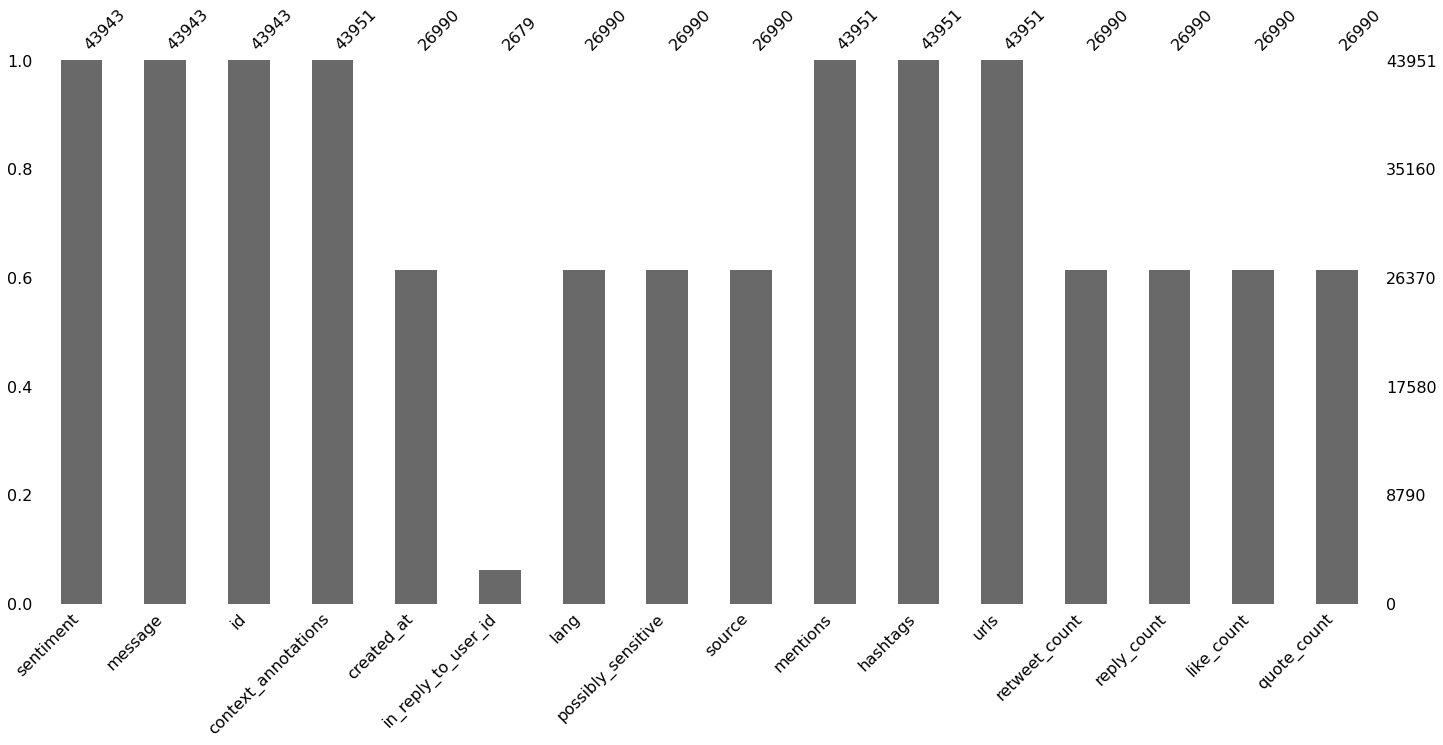

In [19]:
# missing value percentage
msno.bar(labelled_with_meta)

Since `sentiment` is our **target variable**. First, we gonna drop all the rows which missing it.

In [20]:
labelled_with_meta = labelled_with_meta.dropna(subset= ['sentiment'])

For column such as `in_reply_to_user_id`, we go create new column called `in_reply_to_user` to capture whether the tweet reply to user or not. 

In [21]:
import math
labelled_with_meta['in_reply_to_user'] = labelled_with_meta.in_reply_to_user_id.apply(lambda x: 0 if math.isnan(x) else 1)
labelled_with_meta.drop('in_reply_to_user_id', axis=1, inplace=True)

Now we will fill all the missing value with `mode()` of each columns.

In [22]:
dict_fill = {'retweet_count': 0,
             'reply_count': 0,
             'like_count': 0,
             'quote_count': 0,
             'possibly_sensitive': False,
             'source': 'Twitter for iPhone',
             'lang' : 'en',
             'created_at': '2016-11-16 19:10:03+00:00'
             }

for col, var in dict_fill.items():
    labelled_with_meta[col] = labelled_with_meta[col].fillna(var) 

<AxesSubplot:>

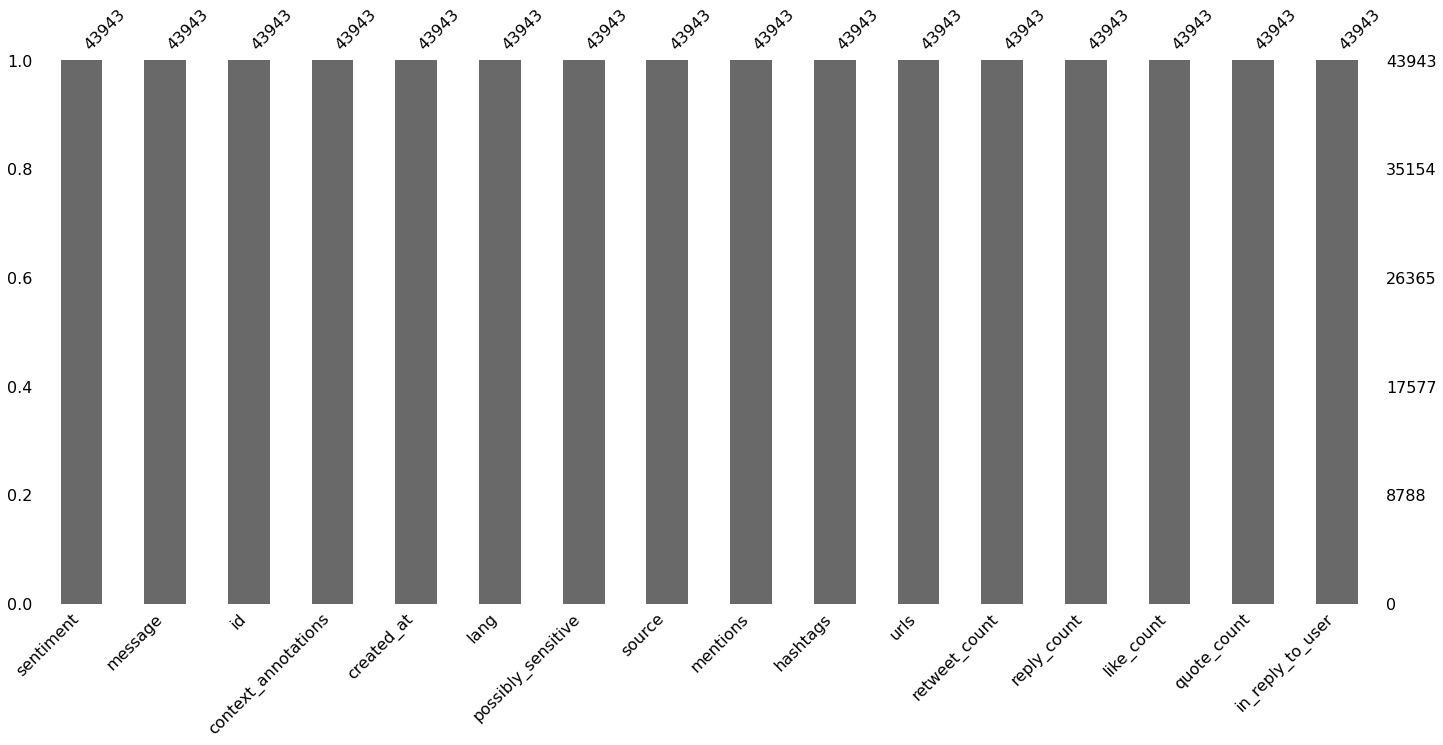

In [23]:
# missing value percentage
labelled_clean = labelled_with_meta.copy()
msno.bar(labelled_clean)

## Unlabelled Data

This unlabelled dataset was scraped with `twarc` according to following keywords:
* #climatechange
* #energy
* #renewables
* #renewableenergy
* #solar
* #climate
* #water
* #cleanenergy
* #climateaction
* #solarenergy
* #windpower
* #environment
* #eco
* climate
* climate change
* environment


Source: Twitter API

Size of Dataset: 99940 x 159

In [24]:
from twarc.expansions import flatten

def transform_data_(path_):
    """
    Reads a folder and transforms all json and jsonl files output by Twarc 
    into a single dataframe

    param: path_ Path to folder containing json/jsonl files
    returns: A pandas dataframe representation of the tweets and metadata
    output by Twarc
    """
    def flatten_json(json_object):
        with open(json_object, "r") as infile:
            data = [flatten(json.loads(line)) for line in infile]
        
        return data

    def dict_to_cols(df, col, prefix=""):
        tmp = pd.json_normalize(df[col]).add_prefix(prefix)
        df.drop(columns=[col], inplace=True)
        return pd.concat([df, tmp], axis=1).reset_index(drop=True)
    
    nested_cols = [
                    {'col': 'attachments', 'prefix': 'attachment_'},
                    {'col': 'entities', 'prefix': 'entities_'},
                    {'col': 'public_metrics', 'prefix': 'public_metrics_'},
                    {'col': 'author', 'prefix': 'author_'},
                    {'col': '__twarc', 'prefix': '__twarc_'},
                    {'col': 'in_reply_to_user', 'prefix': 'in_reply_to_user_'},
                    {'col': 'referenced_tweets', 'prefix': 'referenced_tweets_'}
                    ]
    data = []
    print('Dowload file into json objects list...')
    for file in os.listdir(path_):
        print(os.path.join(path_, file))
        data += flatten_json(os.path.join(path_, file))
    
    print('DataFrame construction...')
    df = pd.concat(list(map(pd.DataFrame.from_dict, data))).reset_index(drop=True)
    
    print('Unnested cols...')
    df['referenced_tweets'] = df['referenced_tweets'].apply(lambda x: x[0] if isinstance(x, list) else x)
    df.drop(columns=['context_annotations'], inplace=True)
    for col in nested_cols:
        df = dict_to_cols(df, col['col'], col['prefix'])
    return df

In [25]:
unlabelled = transform_data_(os.path.join(PROJECT_DIR, 'data/unlabeled'))
unlabelled.shape

Dowload file into json objects list...
/Users/mahora65/Desktop/ML-group/data/unlabeled/stream.jsonl
/Users/mahora65/Desktop/ML-group/data/unlabeled/green.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/steam2.jsonl
/Users/mahora65/Desktop/ML-group/data/unlabeled/tweets_terje.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/sustainable.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/stream1.jsonl
/Users/mahora65/Desktop/ML-group/data/unlabeled/climate.json
DataFrame construction...
Unnested cols...


(99940, 159)

When we scrape tweets from the Twitter API we will get tweets from multiple languages. However, since most NLP packages mostly only work on **English**. We will drop all other languages.

In [26]:
# top 10 language in unlabelled dataset
unlabelled['lang'].value_counts().nlargest(10)

en     92367
und     3628
it      1082
ja       429
es       407
fr       299
de       192
ko       159
pt       128
in       126
Name: lang, dtype: int64

In [27]:
unlabelled = unlabelled[unlabelled['lang'] == 'en']
unlabelled.shape

(92367, 159)

Like what we do in labelled dataset, there are some columns which we want to transform it into a binary data.

In [28]:
def transform_references_binary(df, col_prefix, id_col=None):
    cols = [col for col in df.columns if col_prefix in col]
    if not id_col:
        id_col = f"{col_prefix}_id"
    print(id_col, cols)
    binar_col = (df.copy()
        .loc[:, id_col]
        .fillna(0)
        .apply(lambda x: np.where(x == 0, 0, 1))
        .rename(col_prefix)
        )
    
    transformed_df = (pd.concat([df, binar_col], axis=1)
                    .drop(cols, axis=1)
                    )

    return  transformed_df

unlabelled= (unlabelled.loc[:,~unlabelled.columns.duplicated()]
                     .pipe(transform_references_binary, "referenced_tweets")
                     .pipe(transform_references_binary, "in_reply_to_user")
                     .pipe(transform_references_binary, "attachment_poll", "attachment_poll.id")
                     .pipe(transform_references_binary, "attachment_media", "attachment_media")
                     )

Now we check for the missing value.

<AxesSubplot:>

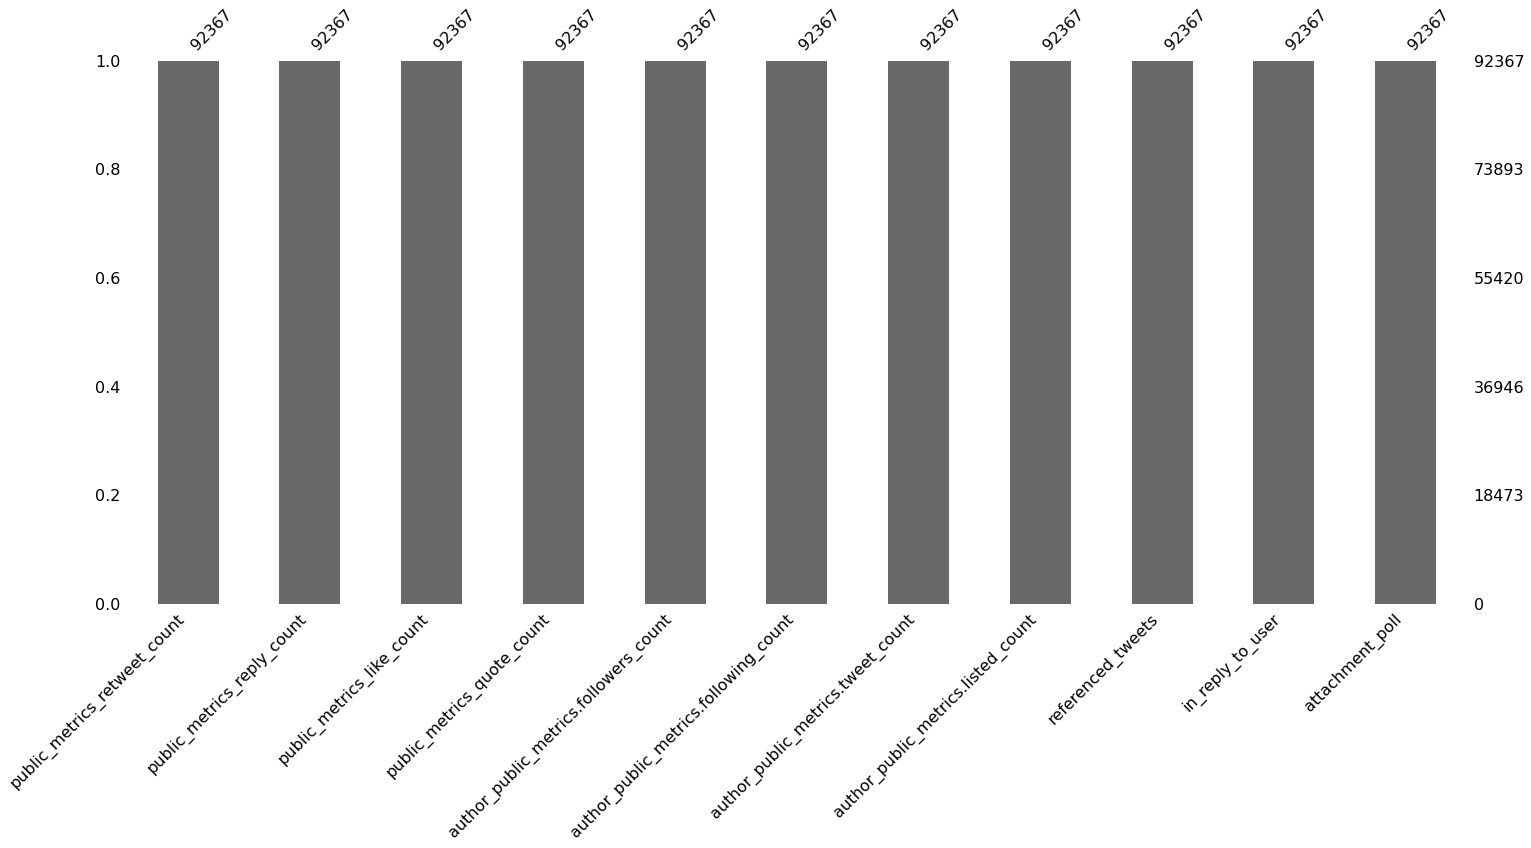

In [29]:
# check numerical cols null
msno.bar(unlabelled.select_dtypes(include= 'number'))

<AxesSubplot:>

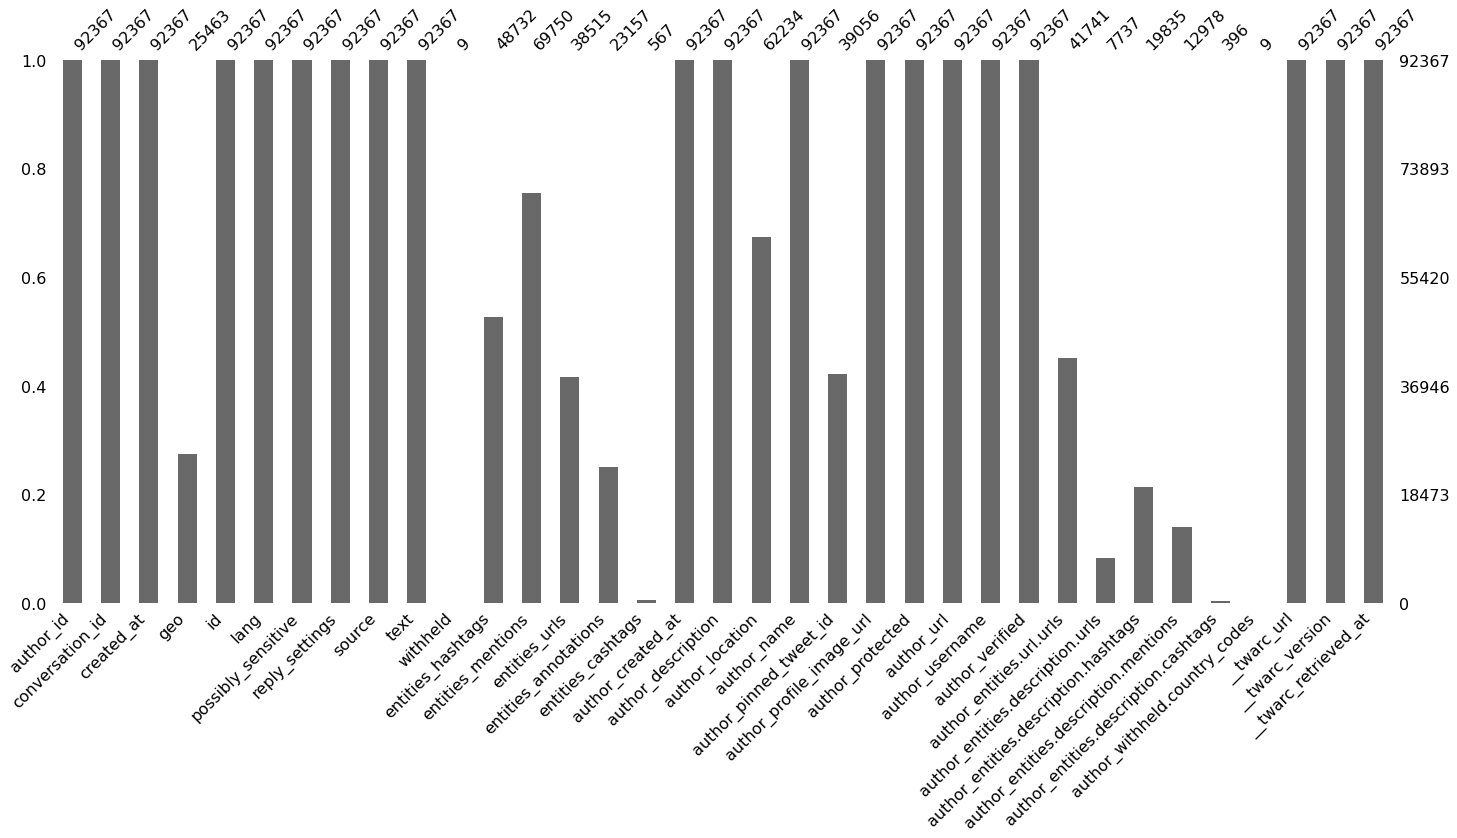

In [30]:
# check non-numerical cols null
msno.bar(unlabelled.select_dtypes(include= ['bool', 'object']))

First, we investigating `geo` cols.

<AxesSubplot:>

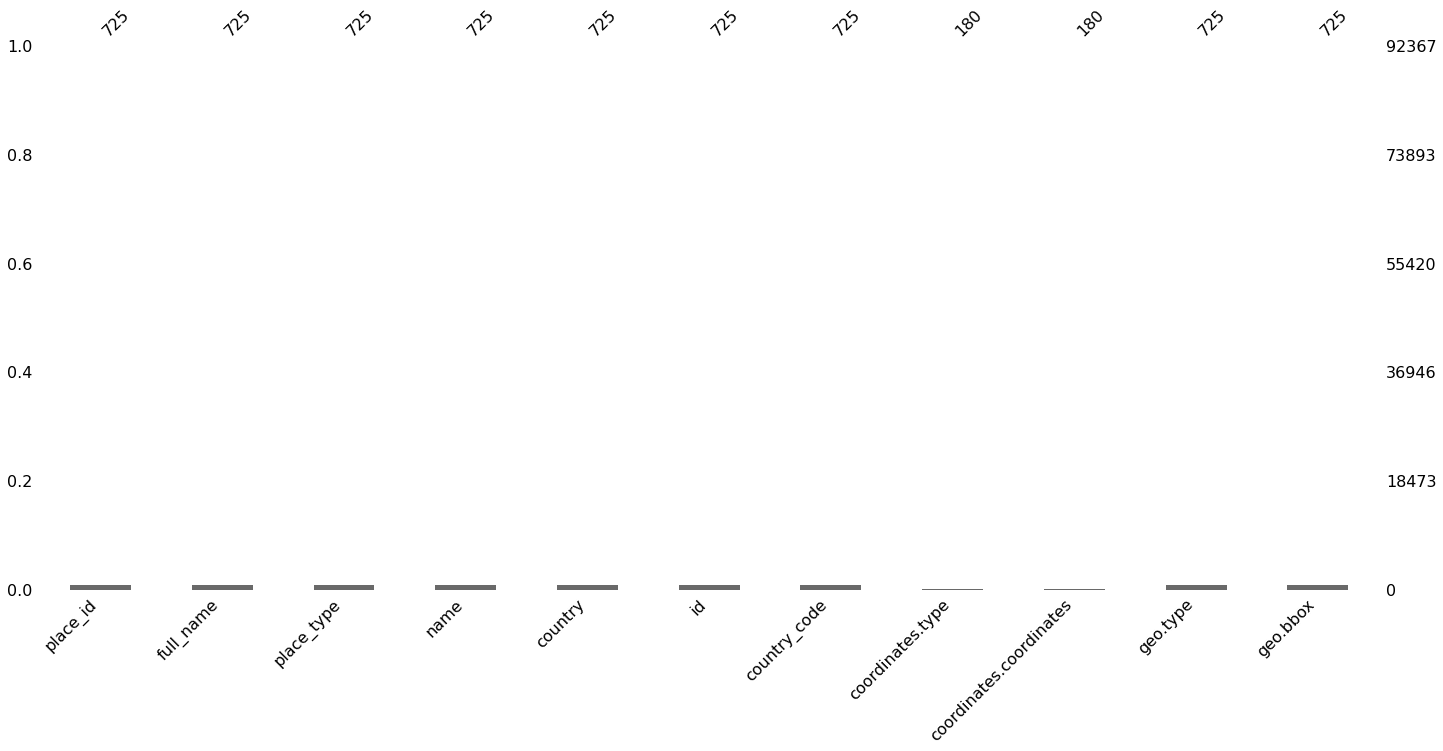

In [31]:
msno.bar(pd.json_normalize(unlabelled.geo))

We can see the there are only 725 non-missing values out of 92367 observations. There are too many missing value and this columns barely contains information at all. Therefore, we will drop it.

Next, we look at `author_entities`

<AxesSubplot:>

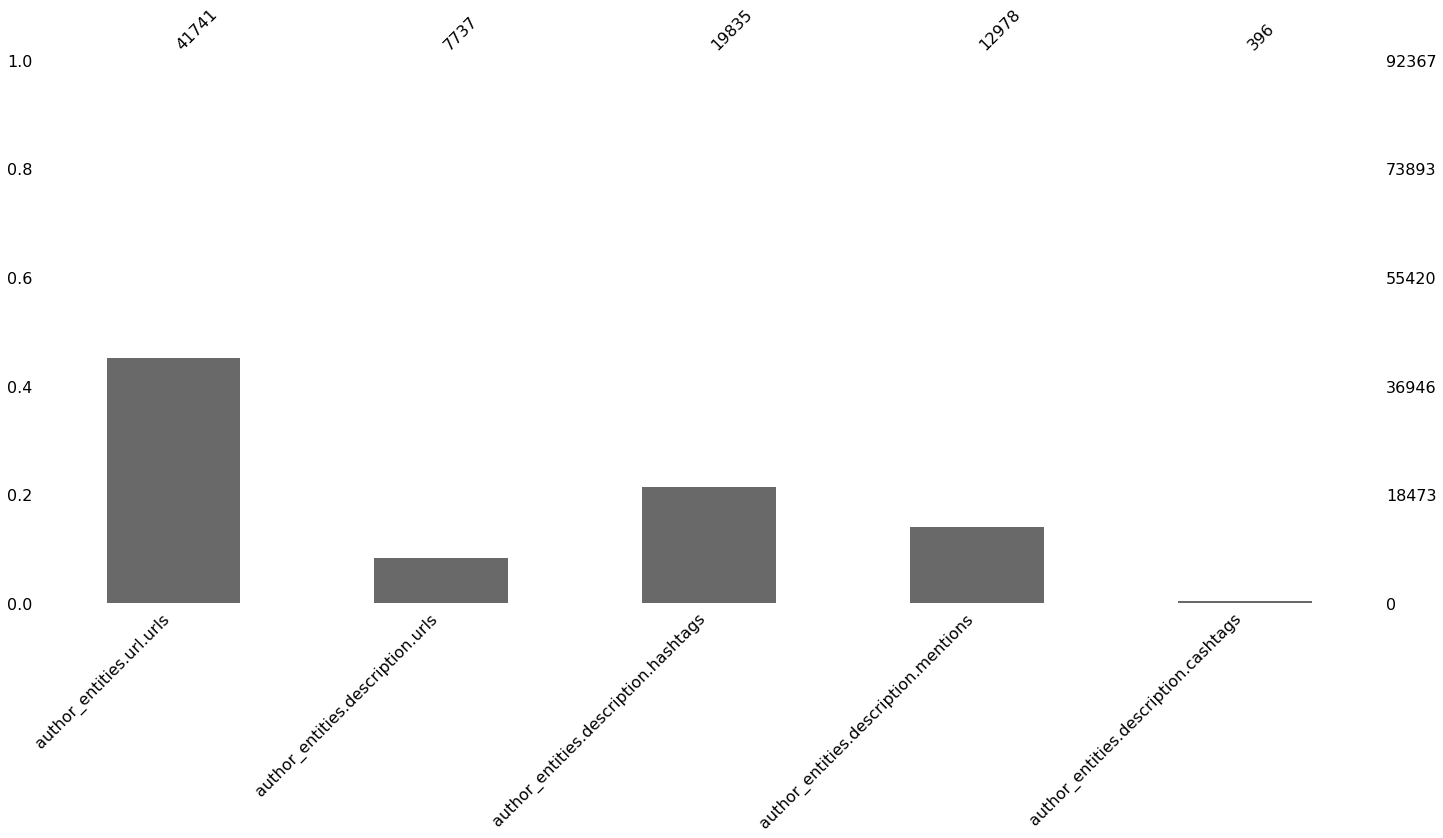

In [32]:
msno.bar(unlabelled[[col for col in unlabelled.columns if 'author_entities' in col]])

The columns from `author_entities` is also barely contains any information at all. We will also drop them along with all the columns which has too many missing value.

In [33]:
cols = ['geo', 'author_withheld.country_codes', 'withheld', 'entities_cashtags', 'entities_annotations', 'author_pinned_tweet_id'] + [col for col in unlabelled.columns if 'author_entities' in col]
unlabelled.drop(cols, axis=1, inplace=True)
unlabelled.shape

(92367, 35)

In [34]:
unlabelled.head(3)

,author_id,conversation_id,created_at,id,lang,possibly_sensitive,reply_settings,source,text,entities_hashtags,...,author_public_metrics.followers_count,author_public_metrics.following_count,author_public_metrics.tweet_count,author_public_metrics.listed_count,__twarc_url,__twarc_version,__twarc_retrieved_at,referenced_tweets,in_reply_to_user,attachment_poll
2,763555118,1493879484147195904,2022-02-16T09:26:38.000Z,1493879484147195904,en,False,everyone,Twitter for Android,RT @unescoEARTH: Are you able to demonstrate t...,"[{'start': 64, 'end': 75, 'tag': 'geoscience'}...",...,67,1182,534,1,https://api.twitter.com/2/tweets/search/stream...,2.9.2,2022-02-16T09:26:49+00:00,1,0,0
7,1160944927657857028,1493879570684076039,2022-02-16T09:26:59.000Z,1493879570684076039,en,False,everyone,Twitter for iPhone,RT @FikreJesus: 🇪🇷leaving no one behind means ...,"[{'start': 121, 'end': 126, 'tag': 'SDGs'}, {'...",...,1011,520,32473,0,https://api.twitter.com/2/tweets/search/stream...,2.9.2,2022-02-16T09:27:09+00:00,1,0,0
13,1272902594302803970,1493885801515601921,2022-02-16T09:56:11.000Z,1493886919679397890,en,False,everyone,Twitter for Android,accessing education.\nOur goal at JEF is to en...,"[{'start': 55, 'end': 65, 'tag': 'everygirl'},...",...,20,52,194,0,https://api.twitter.com/2/tweets/search/stream...,2.9.2,2022-02-16T09:56:22+00:00,1,1,0


We still need to decode `entities_hashtags`, `entities_mentions`, and `entities_urls`.

In [35]:
for key, var in {'entities_hashtags': 'tag', 'entities_mentions': 'username', 'entities_urls': 'expanded_url'}.items():
    unlabelled[key] = unlabelled[key].apply(lambda y: [x[var] for x in y] if isinstance(y, list) else [])

<AxesSubplot:>

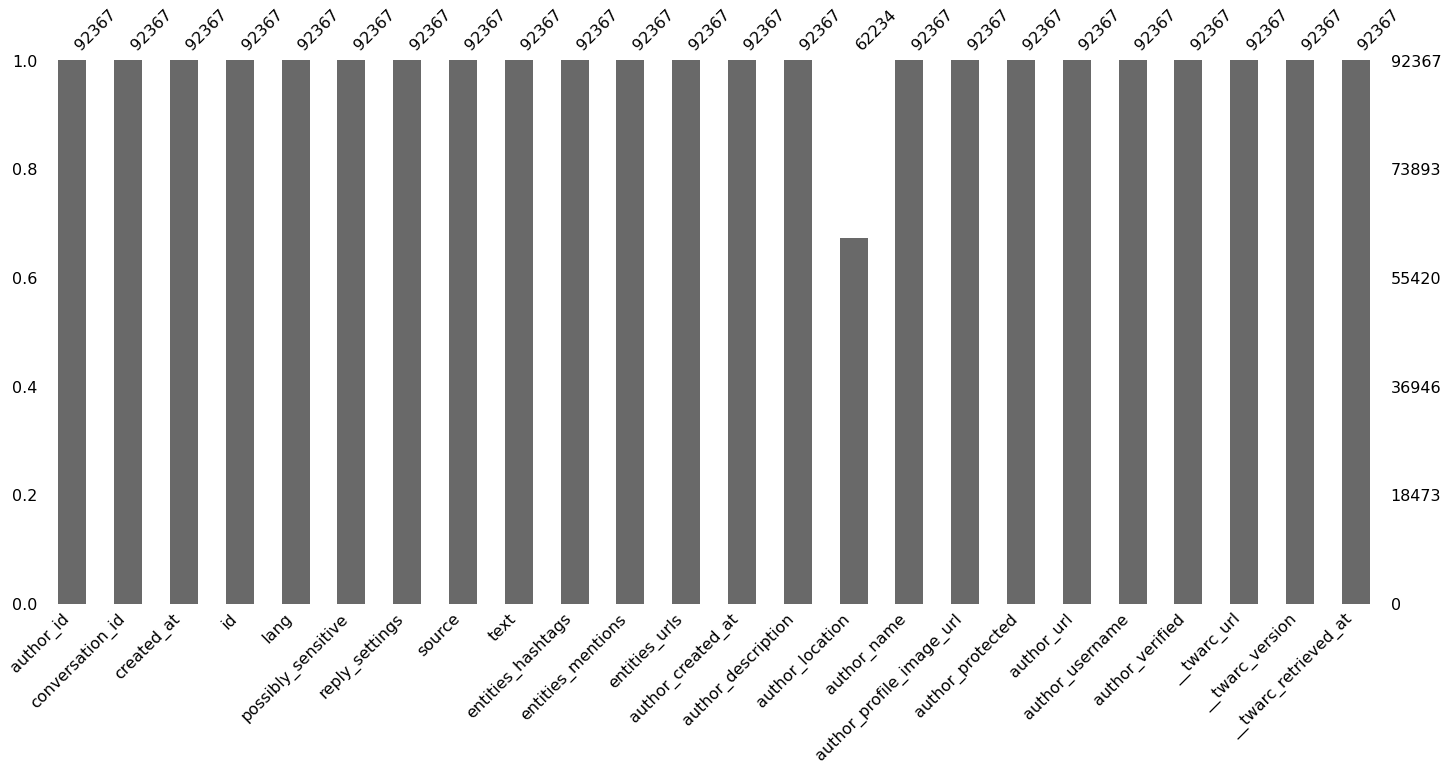

In [36]:
# check non-numerical cols null
msno.bar(unlabelled.select_dtypes(include= ['bool', 'object']))

## Dealing with author locations

The author location column represents a free text field where the tweet author can put any free form text. As such, it has a wide variety of text data, with some being locations and some not. Furthermore, some of the locations might contain spelling errors, and can be a mix of city, country, region etc.

It could still be useful to include the column in our model, so we will try to process the column using the geograpy3 package. Geograpy3 uses NLTK entity matching to find locations in text. It could allow us to extract country names from the relativelty messy author_location column.

In [37]:
# import geograpy

# unique_locations = pd.DataFrame([[k,v.values]
#                         for k,v in unlabelled.groupby('author_location').groups.items()], 
#                       columns=['author_location','indices'])

# unique_locations["author_location"].fillna("none").apply(lambda x: geograpy.get_place_context(text=x).countries)

# unlabelled["author_location"] = (unlabelled["author_location"].fillna("none")
#                                         .apply(lambda x: geograpy.get_place_context(text=x).countries))

In [38]:
unlabelled_cleaned = unlabelled.copy()

Now we merging the data

In [39]:
# Merging the data
rename_cols = {"text": "message", "entities_hashtags": "hashtags", 
               "entities_mentions": "mentions", "entities_urls": "urls"}

unlabelled_cleaned.columns = unlabelled_cleaned.columns.str.replace("public_metrics_", "")
unlabelled_cleaned.columns = unlabelled_cleaned.columns.str.replace("entities_", "")
unlabelled_cleaned = unlabelled_cleaned.rename(columns=rename_cols)

joined = labelled_clean.append(unlabelled_cleaned).reset_index(drop= True)
joined.shape

/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_4792/1817362512.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joined = labelled_clean.append(unlabelled_cleaned).reset_index(drop= True)


(136310, 37)

# Clustering

ours aim is to assign a label to unlabelled dataset by clustering it with labelled dataset.

## Labelled data

First, we need to get numerical values and split the labels.

In [40]:
num_labelled = labelled_clean.select_dtypes(include= 'number')
y = num_labelled['sentiment']
num_labelled = num_labelled.drop(['id', 'sentiment'], axis=1)

We have 7 numerical attribute in total. if we need to plot his it will be 7 dimensional plot which is beyond humans perceptions. We gonna use PCA to reduces it to 2D.

<AxesSubplot:xlabel='x', ylabel='y'>

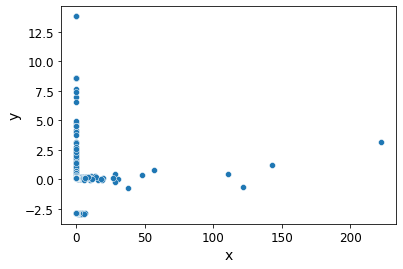

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
pca_2 = PCA(n_components= 2)
std_labelled = std_scaler.fit_transform(num_labelled)
X2D = pca_2.fit_transform(std_labelled)
labelled_X2D = pd.DataFrame(X2D, columns= ['x','y'])

sns.scatterplot(x= 'x', y= 'y', data= labelled_X2D)

Then, we try cluster the dataset with `KMeans` with 4 cluster, which is equal to 4 classes of labels.

In [42]:
from sklearn.cluster import KMeans

km_cluster = KMeans(
    n_clusters=4, init= 'random',
    n_init = 20, max_iter= 10_000,
    tol= 1e-04, random_state=0
)


y_km = km_cluster.fit_predict(labelled_X2D)

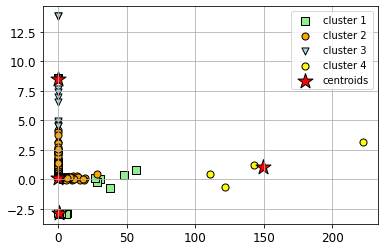

In [43]:
plt.scatter(
    labelled_X2D[y_km==0]['x'], labelled_X2D[y_km==0]['y'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    labelled_X2D[y_km == 1]['x'], labelled_X2D[y_km == 1]['y'],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    labelled_X2D[y_km == 2]['x'], labelled_X2D[y_km == 2]['y'],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    labelled_X2D[y_km == 3]['x'], labelled_X2D[y_km == 3]['y'],
    s=50, c='yellow',
    marker='o', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    km_cluster.cluster_centers_[:, 0], km_cluster.cluster_centers_[:, 1],
    s=250, marker="*",
    c='red', edgecolor='black',
    label= 'centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Now we plot the distribution of the class and cluster with heatmap.

<AxesSubplot:xlabel='sentiment', ylabel='row_0'>

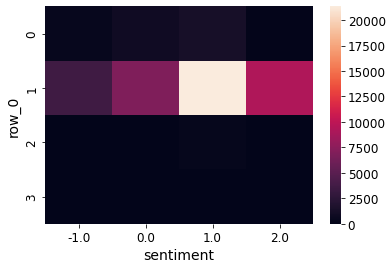

In [44]:
sns.heatmap(pd.crosstab(y_km, y))

## Unlabelled data

In [45]:
num_unlabelled = unlabelled_cleaned.select_dtypes(include= 'number')
num_unlabelled.shape

(92367, 11)

We have 11 numberical attribute in total. If we need to plot this it will be 11 

<AxesSubplot:xlabel='x', ylabel='y'>

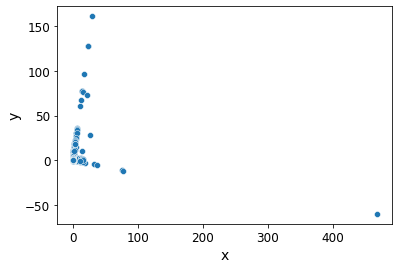

In [46]:
std_df = std_scaler.fit_transform(num_unlabelled)
X2D = pca_2.fit_transform(std_df)
unlabelled_X2D = pd.DataFrame(X2D, columns=['x', 'y'])


sns.scatterplot(x= 'x', y= 'y', data= unlabelled_X2D)

Now we have to check outliners, we have 2 on the `x` axis and 3 on the `y` axis

In [47]:
# outliner on x axis
unlabelled.iloc[unlabelled_X2D.nlargest(2, 'x').index]

,author_id,conversation_id,created_at,id,lang,possibly_sensitive,reply_settings,source,text,entities_hashtags,...,author_public_metrics.followers_count,author_public_metrics.following_count,author_public_metrics.tweet_count,author_public_metrics.listed_count,__twarc_url,__twarc_version,__twarc_retrieved_at,referenced_tweets,in_reply_to_user,attachment_poll
48568,124003770,1493839647696326659,2022-02-16T07:37:19.000Z,1493851972755021824,en,False,everyone,Tweetbot for iΟS,"@guinghyung BRAVO‼️LET WOMEN DO IT‼️LET LENI,&...",[2GETHERWERSTRONG],...,3976198,192,35366,11739,https://api.twitter.com/2/tweets/search/recent...,2.9.2,2022-02-16T08:41:26+00:00,1,1,0
97792,1484309498458443776,1492467184496349184,2022-02-12T11:54:40.000Z,1492467184496349184,en,False,everyone,Twitter Media Studio,We fixed it #auspol #climate https://t.co/WeLk...,"[auspol, climate]",...,1316,1404,107,4,https://api.twitter.com/2/tweets/search/recent...,2.9.2,2022-02-16T08:51:36+00:00,0,0,0


In [48]:
# outliner on y axis
unlabelled.iloc[unlabelled_X2D.nlargest(3, 'y').index]

,author_id,conversation_id,created_at,id,lang,possibly_sensitive,reply_settings,source,text,entities_hashtags,...,author_public_metrics.followers_count,author_public_metrics.following_count,author_public_metrics.tweet_count,author_public_metrics.listed_count,__twarc_url,__twarc_version,__twarc_retrieved_at,referenced_tweets,in_reply_to_user,attachment_poll
33682,5988062,1493999013351370756,2022-02-16T17:21:36.000Z,1493999013351370756,en,False,everyone,SocialFlow,“Xi Jinping indulges Vladimir Putin because Ru...,[],...,26235642,136,294455,119539,https://api.twitter.com/2/tweets/search/stream...,2.9.2,2022-02-16T17:21:47+00:00,0,0,0
21828,2467791,1493975237267968007,2022-02-16T15:47:07.000Z,1493975237267968007,en,False,everyone,SocialFlow,"Student climate activists from Yale, Stanford,...",[],...,18696312,1715,419195,104913,https://api.twitter.com/2/tweets/search/stream...,2.9.2,2022-02-16T15:47:18+00:00,0,0,0
31242,14293310,1493994332810059778,2022-02-16T17:03:00.000Z,1493994332810059778,en,False,everyone,Sprinklr,The megadrought deepened so much last year tha...,[],...,18591021,509,387376,104922,https://api.twitter.com/2/tweets/search/stream...,2.9.2,2022-02-16T17:03:11+00:00,0,0,0


**Observation**
* The outliner on `x` axis are tweets which is popular itself.
* The outliner on `y` axis are tweets that come from popular authors

[]

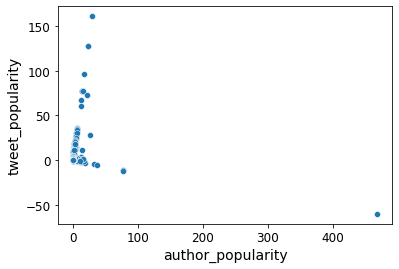

In [49]:
sns.scatterplot(x= 'x', y= 'y', data= unlabelled_X2D)
plt.xlabel('author_popularity')
plt.ylabel('tweet_popularity')
plt.plot()

We will try remove the outliner to zoom into the cluster

[]

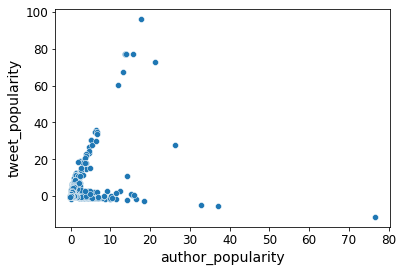

In [50]:
# remove outliner
outliner_rows = list(unlabelled_X2D.nlargest(2, 'x').index) + list(unlabelled_X2D.nlargest(3, 'y').index)

unlabelled_X2D.drop(outliner_rows, inplace= True)
sns.scatterplot(x= 'x', y= 'y', data= unlabelled_X2D)
plt.xlabel('author_popularity')
plt.ylabel('tweet_popularity')
plt.plot()

In [51]:
from sklearn.cluster import KMeans

km_cluster = KMeans(
    n_clusters=4, init= 'random',
    n_init = 20, max_iter= 1_000,
    tol= 1e-04, random_state=0
)

y_km = km_cluster.fit_predict(unlabelled_X2D)

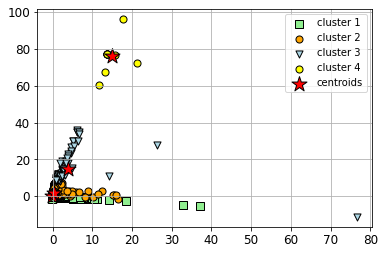

In [52]:
plt.scatter(
    unlabelled_X2D[y_km==0]['x'], unlabelled_X2D[y_km==0]['y'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    unlabelled_X2D[y_km == 1]['x'], unlabelled_X2D[y_km == 1]['y'],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    unlabelled_X2D[y_km == 2]['x'], unlabelled_X2D[y_km == 2]['y'],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    unlabelled_X2D[y_km == 3]['x'], unlabelled_X2D[y_km == 3]['y'],
    s=50, c='yellow',
    marker='o', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    km_cluster.cluster_centers_[:, 0], km_cluster.cluster_centers_[:, 1],
    s=250, marker="*",
    c='red', edgecolor='black',
    label= 'centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## Semi-labelled

In [53]:
num_join = joined.select_dtypes(include= 'number')
y = num_join['sentiment']
num_join = num_join.drop('sentiment', 1)

/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_4792/2715682597.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  num_join = num_join.drop('sentiment', 1)


We can see that all the unlabelled data in `y` doesn't have any values. we gonna fill it with `-5` to make it distinguable from normal label.

In [54]:
# all the missing labels
y.isnull().sum()

92367

In [55]:
# fill na with -5 for unlabelled data
y = y.fillna(-5)

Now we check `num_joined`.

<AxesSubplot:>

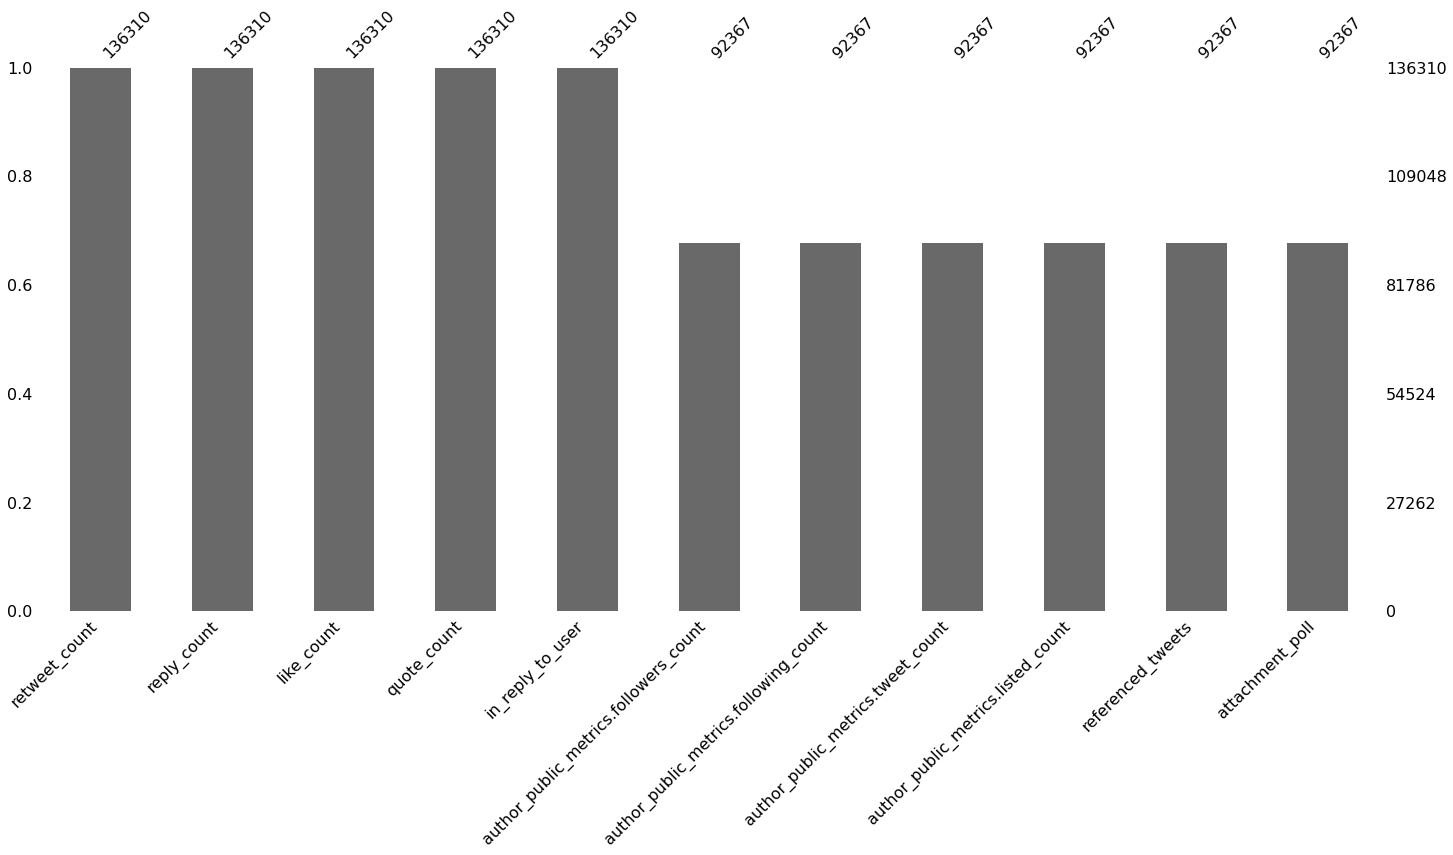

In [56]:
msno.bar(num_join)

again, we will fill all the missing value with `mode` of each columns.

In [57]:
dict_fill = {'author_public_metrics.followers_count': 546,
             'author_public_metrics.following_count': 547,
             'author_public_metrics.tweet_count': 8.675e+03,
             'author_public_metrics.listed_count': 4,
             'referenced_tweets': 1,
             'attachment_poll': 0
             }

for col, var in dict_fill.items():
    num_join[col] = num_join[col].fillna(var) 

<AxesSubplot:xlabel='x', ylabel='y'>

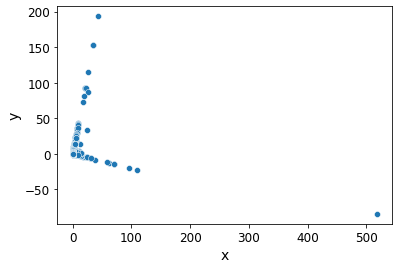

In [58]:
 from sklearn.decomposition import PCA
 from sklearn.preprocessing import StandardScaler

 std_scaler = StandardScaler()
 pca_2 = PCA(n_components= 2)
 std_join = std_scaler.fit_transform(num_join)
 X2D = pca_2.fit_transform(std_join)
 joined_X2D = pd.DataFrame(X2D, columns=['x', 'y'])
 joined_X2D['label'] = y


 sns.scatterplot(x= 'x', y= 'y', data= joined_X2D)

Now, we gonna drop 1 outliner on the `x` axis and 3 on the `y` axis. Then create a cluster.

In [59]:
joined_X2D.drop(list(joined_X2D.nlargest(1, 'x').index) + list(joined_X2D.nlargest(3, 'y').index), inplace= True)

In [60]:
from sklearn.cluster import KMeans

km_cluster = KMeans(
    n_clusters=4, init= 'random',
    n_init = 20, max_iter= 1_000,
    tol= 1e-04, random_state=0
)

y_km = km_cluster.fit_predict(joined_X2D[['x','y']])

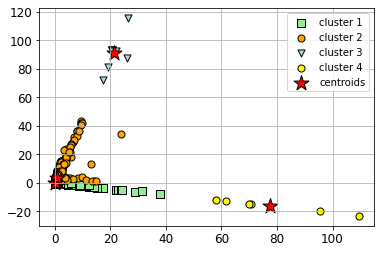

In [61]:
plt.scatter(
    joined_X2D[y_km==0]['x'], joined_X2D[y_km==0]['y'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    joined_X2D[y_km == 1]['x'], joined_X2D[y_km == 1]['y'],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    joined_X2D[y_km == 2]['x'], joined_X2D[y_km == 2]['y'],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    joined_X2D[y_km == 3]['x'], joined_X2D[y_km == 3]['y'],
    s=50, c='yellow',
    marker='o', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    km_cluster.cluster_centers_[:, 0], km_cluster.cluster_centers_[:, 1],
    s=250, marker="*",
    c='red', edgecolor='black',
    label= 'centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

And we plot distribution of the cluster and labels with heatmap.

<AxesSubplot:xlabel='label', ylabel='cluster'>

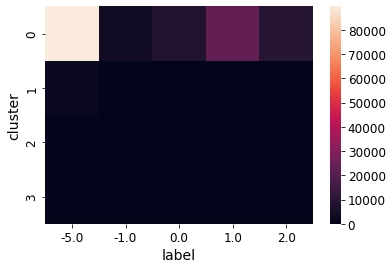

In [62]:
y_semi = pd.DataFrame(list(zip(y_km, joined_X2D['label'])), columns=['cluster', 'label'])

sns.heatmap(pd.crosstab(y_semi['cluster'], y_semi['label']))

In summary we couldn't assign the unlabelled data scraped from twitter api wiht the current labeled data. This might because of the time gaps between two database (labelled-2018, unlabelled-2022).

# EDA
It time to dissect the data, torturing it until it confess everything to us...

![](https://acuate.typepad.com/.a/6a0120a5e84a91970c0223c8514578200c-500wi)


## Preprocessing

In [63]:
df = labelled_clean.copy()

In [64]:
label_dict = {
    2 : 'News',
    1 : 'Pro',
    0 : 'Neutral',
    -1: 'Anti'
}

labels = df.sentiment.copy()
for key, var in label_dict.items():
    labels.loc[labels == key] = var

df['sentiment'] = labels

In [65]:
# Source: https://www.kaggle.com/nicolemeinie/sentiment-analysis-twitter-on-climate-change#Building-classification-models
def TweetCleaner(tweet):
    
    """
    This function uses regular expressions to remove url's, mentions, hashtags, 
    punctuation, numbers and any extra white space from tweets after converting 
    everything to lowercase letters.

    Input:
    tweet: original tweet
           datatype: 'str'

    Output:
    tweet: modified tweet
           datatype: 'str'
    """
    # Convert everything to lowercase
    tweet = tweet.lower() 
    
    # Remove mentions   
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove that funny diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

# Clean the tweets in the message column
df['message'] = df['message'].apply(TweetCleaner)

df.head(3)

,sentiment,message,id,context_annotations,created_at,lang,possibly_sensitive,source,mentions,hashtags,urls,retweet_count,reply_count,like_count,quote_count,in_reply_to_user
0,Anti,climate change is an interesting hustle as it ...,7.929274e+17,"[Extreme Weather + Climate Change, Discovery V...",2016-10-31 03:13:07+00:00,en,False,Twitter for Android,[tiniebeany],[],[],0.0,0.0,0.0,0.0,1
1,Pro,rt watch right here as travels the world to ta...,7.931242e+17,[],2016-11-16 19:10:03+00:00,en,False,Twitter for iPhone,[],[],[],0.0,0.0,0.0,0.0,0
2,Pro,fabulous leonardo s film on change is brillian...,7.931244e+17,[],2016-10-31 16:16:07+00:00,en,False,Twitter Web Client,[YouTube],"[DiCaprio, climate]",[http://www.youtube.com/watch?v=90CkXVF-Q8M&sn...,0.0,0.0,1.0,0.0,0


In [66]:
color_dict = {
    'News': '#FCFC99',
    'Pro': '#79DE79',
    'Neutral': '#A8E4EF',
    'Anti': '#FB6962'
}

## Target Variable Distribution (`sentiment`)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


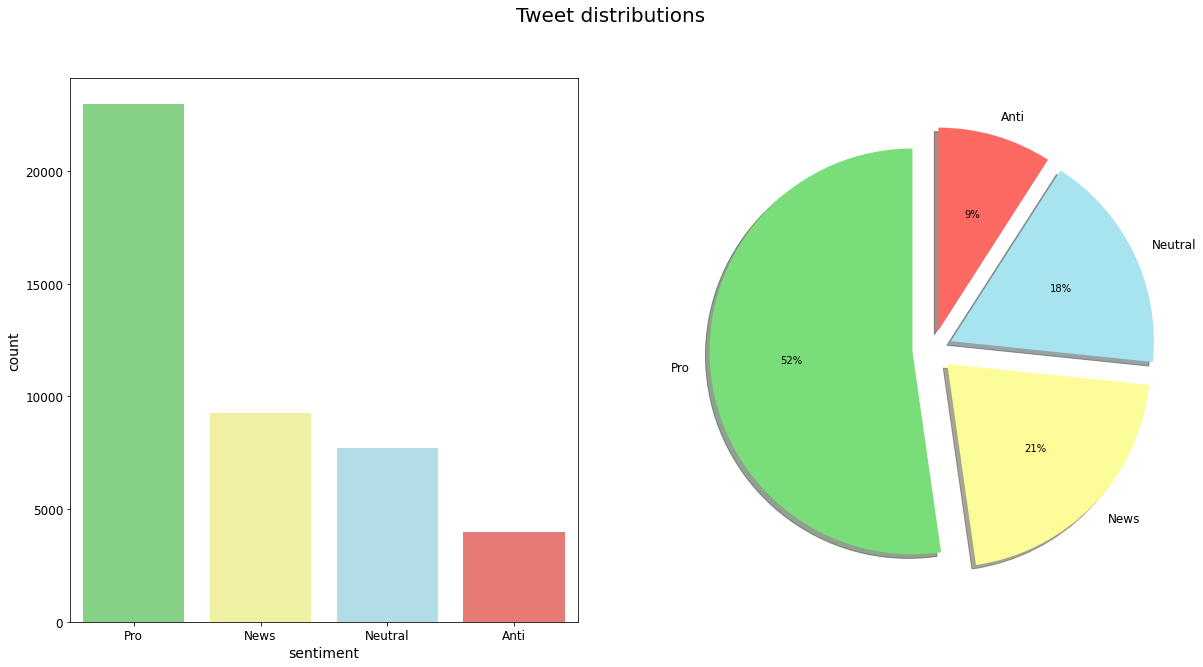

In [67]:
fig, axes = plt.subplots(ncols= 2,
                         nrows= 1,
                         figsize= (20, 10))

order = ['Pro', 'News', 'Neutral', 'Anti']

sns.countplot(labels, ax=axes[0], 
              order= order ,
              palette= [color_dict[x] for x in order])

axes[1].pie(labels.value_counts(),
            labels= ['Pro', 'News', 'Neutral', 'Anti'],
            autopct= '%1.0f%%',
            shadow= True,
            startangle= 90,
            explode= (0.1, 0.1, 0.1, 0.1),
            colors= [color_dict[x] for x in order])
fig.suptitle('Tweet distributions', fontsize=20)
plt.show()

as we can see from graph our dataset is biased toward `Pro` tweets. This should effect greatly when we trying to create a model.

## Tweets Length

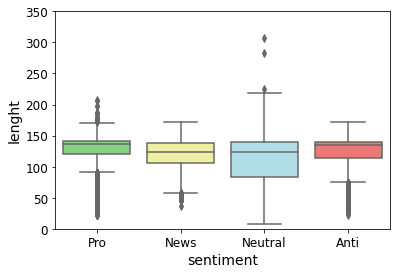

In [68]:
df['lenght'] = labelled_clean.message.str.len()

sns.boxplot(x=df['sentiment'], y=df['lenght'], data=df, order= order, palette= [color_dict[x] for x in order])
plt.ylim(0,350)
plt.show()

The `Neutral` tweets trends to be longer than others.

## Hashtags

In [69]:
import collections

dict= {'Pro': ['pro_hashtags', (0,0)],
       'News': ['news_hashtags', (0,1)],
       'Neutral': ['neutral_hashtags', (1,0)],
       'Anti': ['anti_hashtags', (1,1)]}


for key, var in dict.items():
    tmp = []
    for i in df[df.sentiment == key]['hashtags']:
        tmp += i
    globals()[var[0]] = pd.DataFrame(collections.Counter(tmp).most_common(15), columns=['hashtag', 'count'])

Now we will plot top 15 hashtags by `sentiment`.

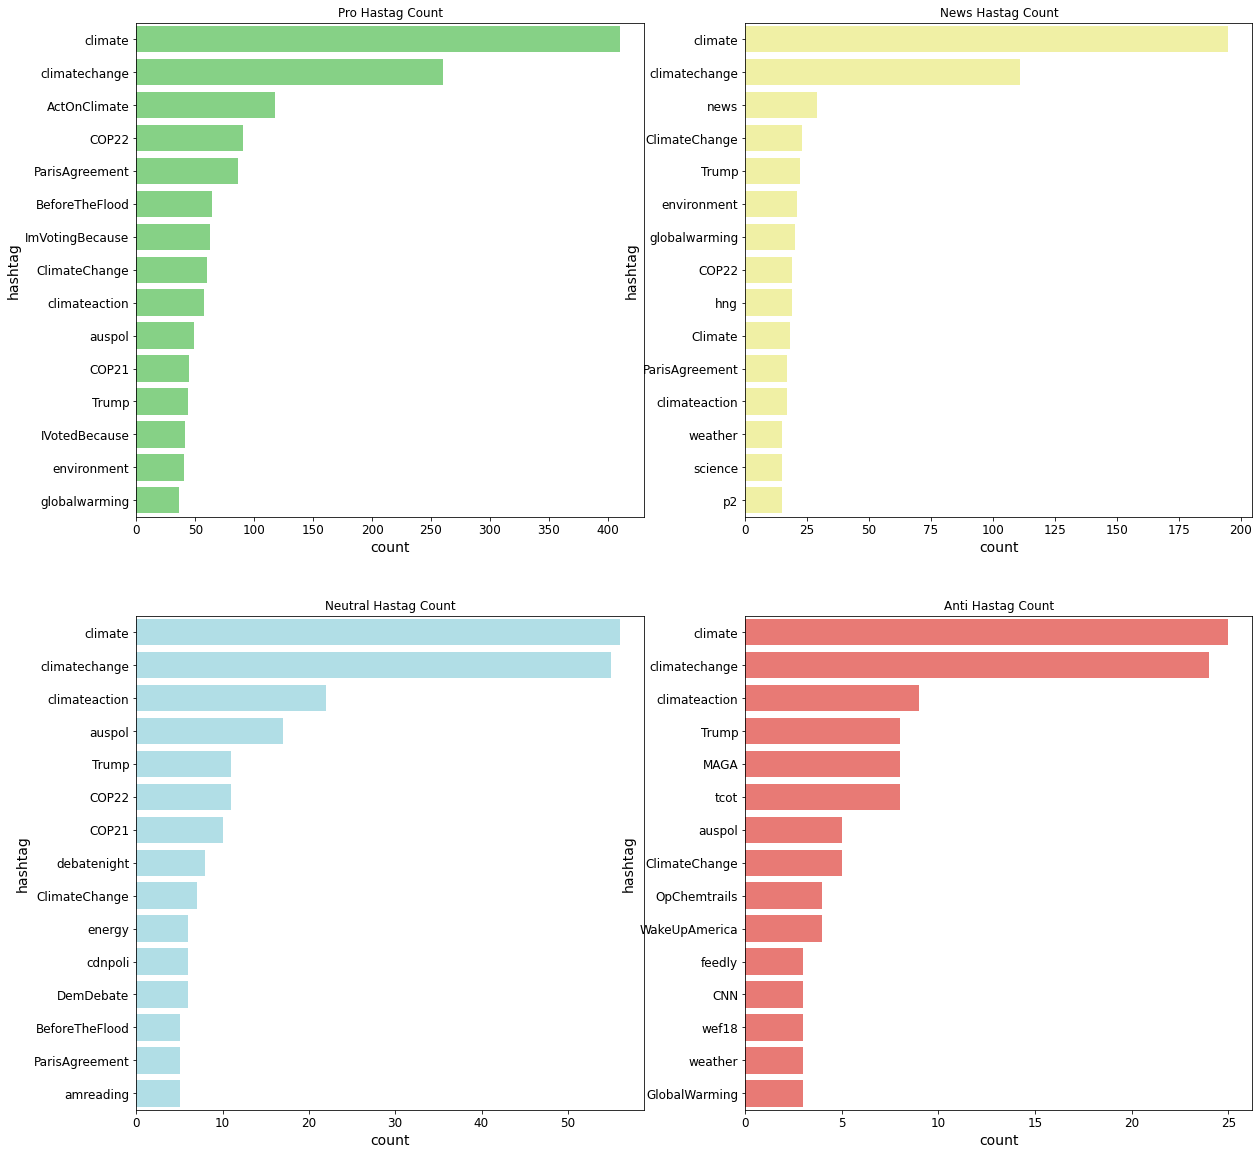

In [70]:
fig, axes = plt.subplots(ncols= 2,
                         nrows= 2,
                         figsize= (20, 20))

for key, var in dict.items():
    sns.barplot(y='hashtag', x='count', data= globals()[var[0]] , ax=axes[var[1]], color=color_dict[key])
    axes[var[1]].set_title(f'{key} Hastag Count')
plt.show()

## Mentions

In [71]:
dict= {'Pro': ['pro_mentions', (0,0)],
       'News': ['news_mentions', (0,1)],
       'Neutral': ['neutral_mentions', (1,0)],
       'Anti': ['anti_mentions', (1,1)]}


for key, var in dict.items():
    tmp = []
    for i in df[df.sentiment == key]['mentions']:
        tmp += i
    globals()[var[0]] = pd.DataFrame(collections.Counter(tmp).most_common(15), columns=['mention', 'count'])

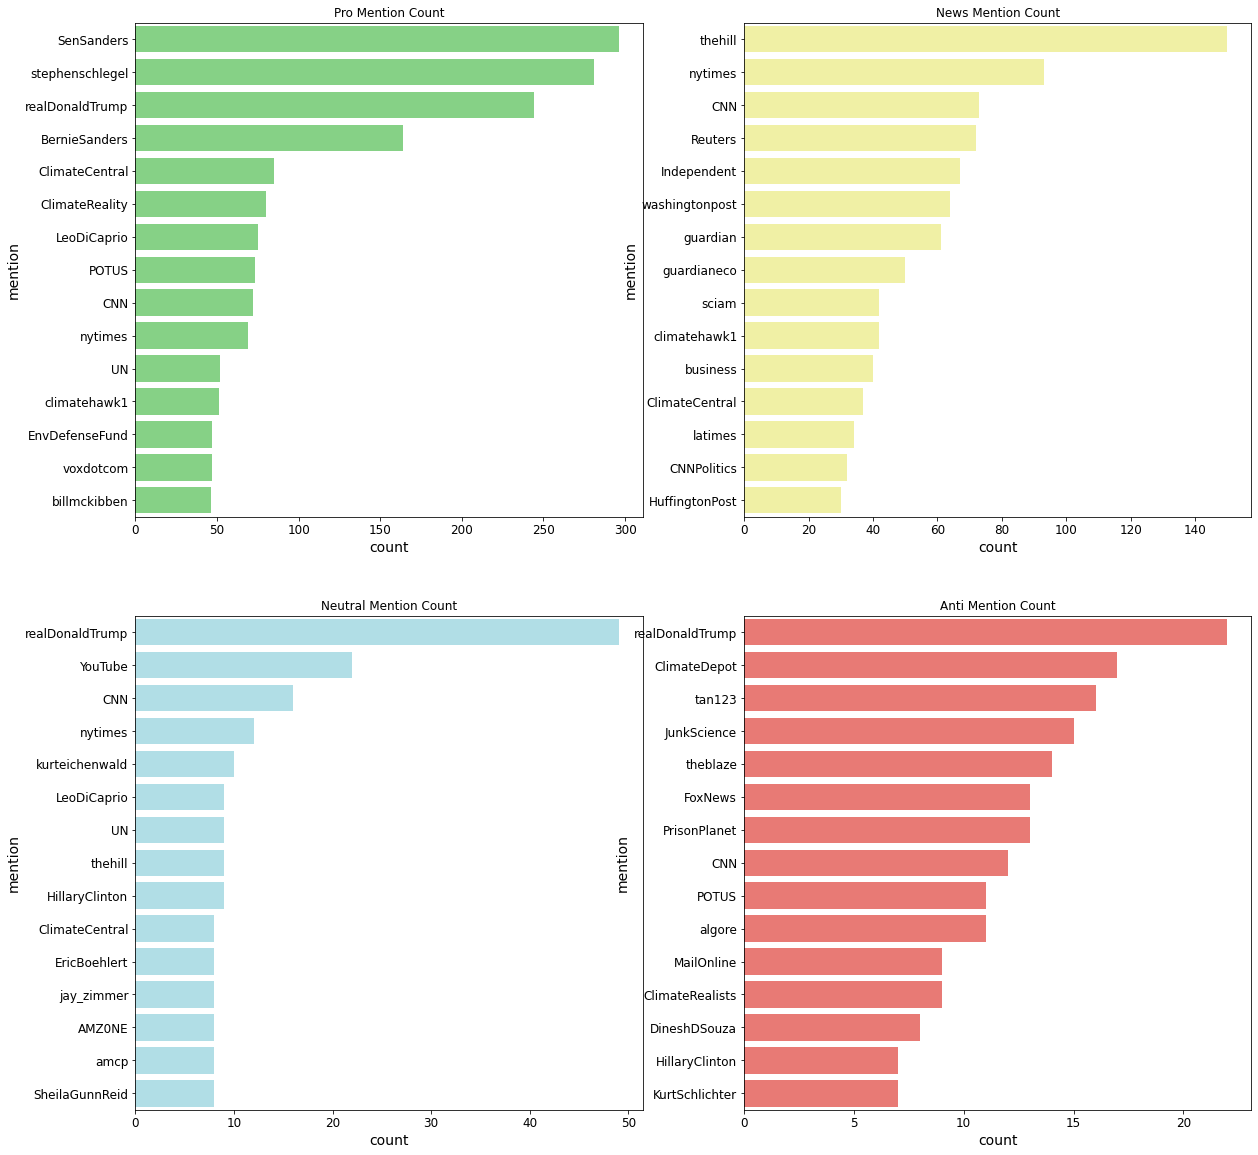

In [72]:
fig, axes = plt.subplots(ncols= 2,
                         nrows= 2,
                         figsize= (20, 20))

for key, var in dict.items():
    sns.barplot(y='mention', x='count', data= globals()[var[0]] , ax=axes[var[1]], color=color_dict[key])
    axes[var[1]].set_title(f'{key} Mention Count')

# Building the models
For our analysis we will focus on 3 models for classification due to hardware and time constraints.

- Random forest
- K nearest neighbor
- Linear SVC


## Splitting into training and test

Before we run our models we'll first split our data into a training and testing set. We'll be using a ratio of 8:2 for the training and test data respectively.

In [73]:
from sklearn.model_selection import train_test_split

# Use same numerical features as for previous clustering
labelled_clean["message"] = labelled_clean["message"].apply(TweetCleaner)
features = labelled_clean.select_dtypes(include=['number']).drop(["id", "sentiment"], axis=1).columns.to_list()
features.append('message')

X = labelled_clean[features]
y = labelled_clean['sentiment'].reset_index(drop=True)

# Splitting into trainng and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,  y_train.shape, X_test.shape, y_test.shape, features

((35154, 6),
 (35154,),
 (8789, 6),
 (8789,),
 ['retweet_count',
  'reply_count',
  'like_count',
  'quote_count',
  'in_reply_to_user',
  'message'])

## Setting up the pipelines
In order to more efficiently run our models we will set up 3 pipelines, one for each model. We will be using the TFIDF vectorized to transform our text into numbers, as machine learning models can only deal with numerical data. TFIDF uses word frequency scores to try to find words that are the most important in a given document, a document being any related collection of words, like a tweet. For the models we'll start with some preset hyperparameters, and then tune them using grid search later on.

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


# https://stackoverflow.com/questions/67768470/valueerror-found-input-variables-with-inconsistent-numbers-of-samples-6-80
transformer = ColumnTransformer(
    [('vec', TfidfVectorizer(stop_words= 'english'), 'message')],   # column should be a string or int
    remainder='passthrough'
)

# Random Forest Classifier
rfc = Pipeline([('tfidf', transformer),
                ('scaler', StandardScaler(with_mean=False)),
               ('clf', RandomForestClassifier(max_depth=5,
                                              n_estimators=100,
                                              random_state=0))])

# K-NN Classifier
knn = Pipeline([('tfidf', transformer),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', KNeighborsClassifier(n_neighbors=5,
                                             metric='minkowski',
                                             p=2))])

# Linear SVC:
lsvc = Pipeline([('tfidf', transformer),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('clf', LinearSVC(class_weight='balanced',
                                   random_state=0))])

## Training the models

We'll pass the training data through each pipeline to end up with our models. We'll then use these models to predict the sentiment on our cross fold validation data.

In [75]:
# Random forest
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)

# K - nearest neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_test)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Functions for evaluating the models
In order to more easily evalute our models we'll create two functions that will take care of most of the work. One function displaying the accuracy, precision, recall and F1 score and one function to do the plotting.

In [76]:
# Set up the function to show model scores
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model):
    print('Model: ', model)
    print('Accuracy: ', accuracy_score(y_test, model.predict(X_test)))
    print('Precision: ', precision_score(y_test, model.predict(X_test), average='weighted'))
    print('Recall: ', recall_score(y_test, model.predict(X_test), average='weighted'))
    print('F1 score: ', f1_score(y_test, model.predict(X_test), average='weighted'))
    print('\n')


In [77]:
# Set up the function to plot the confusion matrix for all models
def plot_confusion_matrix(model, title, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    norm_cm =  cm / cm.sum(axis=1).reshape(-1,1)
    sns.heatmap(norm_cm, annot=True, cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_,
                vmin=0, vmax=1)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Random forest model
Having set up our pipelines it's time for fitting and evaluting the models. We'll start by evaluating the random forest model.


In [78]:
# Fitting the random forest model
rfc.fit(X_train, y_train)
y_rfc_train_pred = cross_val_predict(rfc, X_train, y_train, cv=10)

In [79]:
evaluate_model(rfc)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', RandomForestClassifier(max_depth=5, random_state=0))])
Accuracy:  0.5135965411309592


/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.263781407061685
Recall:  0.5135965411309592
F1 score:  0.34854916735550623




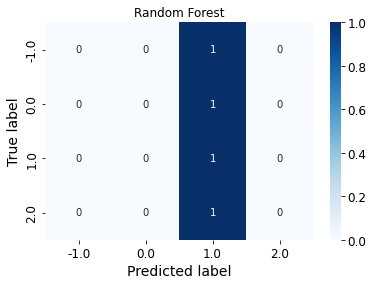

In [80]:
# Plotting the confusion matrix
plot_confusion_matrix(rfc, 'Random Forest', y_rfc_train_pred)

From the confusion matric and the precision, recall, and f1 score we can see that the random forest model is not performinc well. All tweets are predicted as being pro climate change, which is obviously not the case. We'll therefore move on with our other models.


### K-NN model

The K nearest neighbors model uses neighboring data-points to predict which class a new datapoint belongs to using a preset distance measure, like Euclidian distance. It uses majority voting and assigns the data point to the class with the most votes.


In [81]:
knn.fit(X_train, y_train)
y_knn_train_pred = cross_val_predict(knn, X_train, y_train, cv=3)

In [82]:
evaluate_model(knn)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', KNeighborsClassifier())])
Accuracy:  0.539538058937308
Precision:  0.5475638153660617
Recall:  0.539538058937308
F1 score:  0.5396239553886083




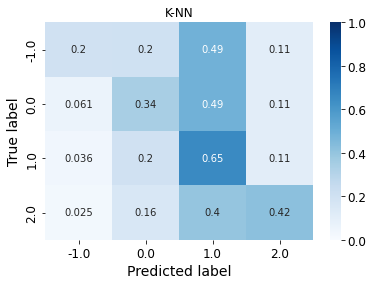

In [83]:
plot_confusion_matrix(knn, 'K-NN', y_knn_train_pred)

### Linear SVC model
SVM works by plotting each data point in n-dimensional space, n-being the number of features. The algorithm then tries to find boundary (called a hyperplane) that will separate the data points into classes.

SVMs are particularly well suited for classification of complex small- or medium-sized datasets and could be a good candidate for our problem definition.


In [84]:
# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = cross_val_predict(lsvc, X_train, y_train, cv=10)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fa

In [85]:
evaluate_model(lsvc)


Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC(class_weight='balanced', random_state=0))])
Accuracy:  0.5966549095460234
Precision:  0.6049330812884658
Recall:  0.5966549095460234
F1 score:  0.6000064565343262




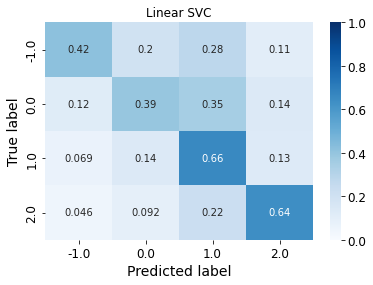

In [86]:
plot_confusion_matrix(lsvc, 'Linear SVC', y_pred_lsvc)

From the confusion matrix and the precision, recall, and f1 score we can see that the K-NN model is performing better than the random forest classifier. It is able to sucessfully classify the tweets from all categories, but performs best on the pro-climate change category. It also performs rather well on the anti-climate change and news categories.


### Linear SVC model
SVM works by plotting each data point in n-dimensional space, n-being the number of features. The algorithm then tries to find boundary (called a hyperplane) that will separate the data points into classes.

SVMs are particularly well suited for classification of complex small- or medium-sized datasets and could be a good candidate for our problem definition.


In [87]:
# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = cross_val_predict(lsvc, X_train, y_train, cv=10)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fa

In [88]:
evaluate_model(lsvc)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC(class_weight='balanced', random_state=0))])
Accuracy:  0.5966549095460234
Precision:  0.6049330812884658
Recall:  0.5966549095460234
F1 score:  0.6000064565343262




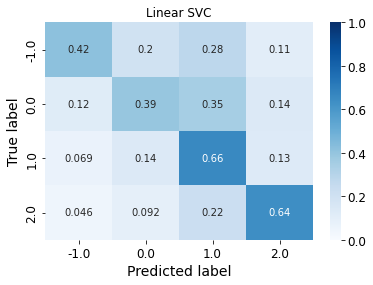

In [89]:
plot_confusion_matrix(lsvc, 'Linear SVC', y_pred_lsvc)

As can be seen by the confusion matrix and the precision, recall, and f1 score, the Linear SVC model performs better than the K-NN model. It is able to successfully classify the tweets from all categories, but performs best on the pro-climate change and news categories. It also performs decently on the anti-climate category.


## Hyperparameter tuning

Having found that the Linear SVC model is the best performing model we will move on with it and perform hyperparameter tuning in order to fine tune the model. Since we are using a larger hyperparameter space, we will use a random search to find the best hyperparameters.

For the hyperparamters we are dealing with two levels of tuning:

1. The first level is the tuning of the hyperparameters for the TFIDF transformer.
2. The second level is the tuning of the hyperparameters of the  Linear SVC model.

For the TFIDF we are using the following hyperparameters:

tfidf__ngram_range: The range of n-grams to consider when building the vocabulary.
min_df: The minimum number of documents a term must appear in to be included in the vocabulary.
max_df: The maximum fraction of documents a term can appear in to be included in the vocabulary.

For the Linear SVC we are using the following hyperparameters:

clf__C: Regularization parameter. A trade between decision boundary and classifying the training points correctly.
clf__max_iter: Maximum number of iterations.
max_features: The number of features to consider when looking for the best split.

In [90]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
param_grid = [{'clf__C': [i for i in np.arange(0.1, 0.6, 0.1)],
              'clf__max_iter': [1500, 2000, 2500, 3000, 4000],
              'tfidf__vec__ngram_range' : [(1,1),(1,2), (1,3)],
              'tfidf__vec__min_df': [2, 3, 4],
              'tfidf__vec__max_df': [0.8, 0.9]},

              {
               'clf__C': [i for i in np.arange(0.1, 0.6, 0.1)],
               'clf__max_iter': [1500, 2000, 2500, 3000, 4000],
               'tfidf__vec__ngram_range' : [(1,1),(1,2), (1,3)],
               'tfidf__vec__min_df': [2, 3, 4],
               'tfidf__vec__max_df': [0.8, 0.9],
               "tfidf__vec__max_features": [i for i in np.arange(5, 100, 2)]}
  ]


svc_mod = LinearSVC(random_state=0)

random_search = RandomizedSearchCV(lsvc, param_grid, cv=5,
                           scoring='f1_weighted',
                           return_train_score=True,
                           n_jobs= -1)

random_search.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fa

KeyboardInterrupt: 

In [ ]:
random_search.best_estimator_

In [ ]:
# Training model using the best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
evaluate_model(best_model)

In [ ]:
plot_confusion_matrix(best_model, "Best model", y_pred)

In [ ]:
accuracy_score(y_pred, y_test)

In [ ]:
print('F1 score improved by',
      round(100*((accuracy_score(y_pred, y_test) - accuracy_score(y_pred_lsvc, y_train)) / accuracy_score(y_pred_lsvc, y_train)),0),
      '%')

After fine tuning our model we can see that the F1 score improved by about 10%, which is a significant improvement. We could improve the model further by adjusting more of the hyperparamters.

Another possible improvement would be to try a different model, such as a neural network, to classify the tweets, as well as feature engineering.

## Conclusion

In this project we have used a combination of different machine learning models to classify tweets as being pro, against, neutral or news about climate change. We started by using the .... dataset. That contained

## References

Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition (2019). Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. [online] O’Reilly | Safari. Available at: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/.

Twitter Climate Change Sentiment Dataset
https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset



‌